<br></br>
# **나이브베이즈 한글 적용**
nltk를 활용한 네이버 영화리뷰 평가모델 [nltk book](https://www.nltk.org/book/ch06.html) | [nltk How to](http://www.nltk.org/howto/classify.html)
1. 0 : 부정적인 리뷰
1. 1 : 긍정적인 리뷰

<br></br>
## **1 NAVER 영화리뷰 데이터 전처리**
1. https://github.com/e9t/nsmc
1. https://www.nltk.org/book/ch06.html

In [1]:
# ! cat ./data/ratings_test.txt | head -n 10

In [2]:
def read_data(filename):
    with open(filename, 'r', encoding='utf-8') as f:
        data = [line.split('\t') for line in f.read().splitlines()]
        data = data[1:]   # header 제외
        
    from random import randint
    random_data = [data[randint(1, len(data))]  for no in range(int(len(data)/20)) ]
    return random_data

In [3]:
train_data = read_data('../data/ratings_train.txt')
test_data  = read_data('../data/ratings_test.txt')

print('Train_data ({})\nsample : {}\nTest_data  ({})\nsample : {}'.format(
    len(train_data), train_data[:3],
    len(test_data),  test_data[:3]))

Train_data (7500)
sample : [['5435159', '헤픈여자들의 어장관리와 걸레모은것같은 삼류상상영화', '0'], ['7655921', '시간남아돌때~잠깐 자고싶은데 잘때가 없을때~~그외 비추~', '0'], ['8905895', '지금봐도 재밌따 ㅎㄷㄷ', '1']]
Test_data  (2500)
sample : [['1736405', '최고의영화', '1'], ['1194109', '작품성은있는듯하나 정말 지루하고 졸림', '0'], ['4392419', '쓰레기같은 연출, 쓰레기같은 메세지', '0']]


In [4]:
%%time
from konlpy.tag import Twitter
twitter = Twitter()

def tokenize(doc):
    result = ['/'.join(t) for t in twitter.pos(doc, norm=True, stem=True)]
    return result 

train_docs = [(tokenize(row[1]), row[2])    for row in train_data]
test_docs  = [(tokenize(row[1]), row[2])    for row in test_data]

from pprint import pprint
pprint(train_docs[:2])

[(['헤픈/Noun',
   '여자/Noun',
   '들/Suffix',
   '의/Josa',
   '어장/Noun',
   '관리/Noun',
   '와/Josa',
   '걸레/Noun',
   '모으다/Verb',
   '같다/Adjective',
   '삼류/Noun',
   '상상/Noun',
   '영화/Noun'],
  '0'),
 (['시간/Noun',
   '남아/Noun',
   '돌때/Noun',
   '~/Punctuation',
   '잠깐/Noun',
   '자다/Verb',
   '자다/Verb',
   '때/Noun',
   '가/Josa',
   '없다/Adjective',
   '때/Noun',
   '~~/Punctuation',
   '그/Determiner',
   '외/Noun',
   '비추다/Verb',
   '~/Punctuation'],
  '0')]
CPU times: user 19.1 s, sys: 229 ms, total: 19.3 s
Wall time: 12.3 s


In [5]:
tokens = [t   for d in train_docs 
              for t in d[0]]
print("Token Total :{}\nSample : {}".format(
    len(tokens), tokens[:5]))

Token Total :109474
Sample : ['헤픈/Noun', '여자/Noun', '들/Suffix', '의/Josa', '어장/Noun']


<br></br>
## **2 nltk 를 활용하여 연산모델 만들기**
https://github.com/e9t/nsmc

In [6]:
import nltk
text = nltk.Text(tokens, name='네이버리뷰')

print("number of Token : {} \nunique Token    : {}\n".format(
    len(text.tokens), len(set(text.tokens))))
pprint(text.vocab().most_common(20))    

number of Token : 109474 
unique Token    : 10882

[('./Punctuation', 3429),
 ('영화/Noun', 2574),
 ('하다/Verb', 2485),
 ('이/Josa', 1898),
 ('보다/Verb', 1687),
 ('의/Josa', 1583),
 ('../Punctuation', 1423),
 ('가/Josa', 1399),
 ('에/Josa', 1384),
 ('을/Josa', 1199),
 ('도/Josa', 1173),
 ('.../Punctuation', 1157),
 (',/Punctuation', 924),
 ('들/Suffix', 920),
 ('은/Josa', 889),
 ('는/Josa', 842),
 ('없다/Adjective', 809),
 ('를/Josa', 758),
 ('있다/Adjective', 617),
 ('좋다/Adjective', 615)]


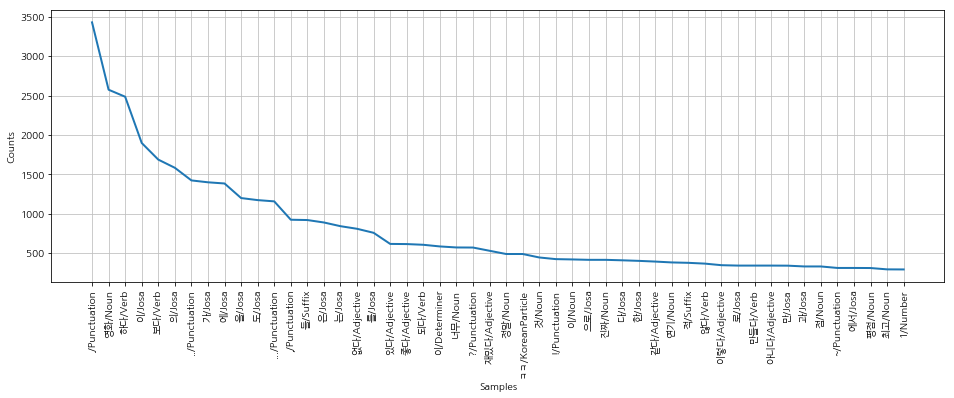

In [7]:
%matplotlib inline
from matplotlib import rc
rc('font', family=['NanumGothic','Malgun Gothic'])

import matplotlib.pyplot as plt
plt.figure(figsize=(16,5))
text.plot(50) 

<br></br>
## **3 모델의 정확도/ 일반화를 높이는 추가작업**
우도 상위 4000개 데이터를 추출

In [8]:
# 검색가능 단어목록 추출하기
selected_words = [f[0] for f in text.vocab().most_common(4000)]
selected_words[:5]

['./Punctuation', '영화/Noun', '하다/Verb', '이/Josa', '보다/Verb']

In [9]:
# Mission 1
# selected 객체를 './data/selected.words' 로 저장하기
import pickle
pickle.dump(selected_words, open('../data/selected.words', 'wb'))

In [10]:
%%time
def term_exists(doc):
    return {'exists({})'.format(word): (word in set(doc)) for word in selected_words}

train_xy   = [(term_exists(d), c) for d, c in train_docs]
test_xy    = [(term_exists(d), c) for d, c in test_docs]

CPU times: user 35 s, sys: 1.22 s, total: 36.2 s
Wall time: 36.2 s


In [11]:
# 문장별 Text을 분석가능한 Token으로 변환
line_num = 130
print("100th 문장 변환된 Token 갯수 : {}\n\nSample : {}".format(
    len(train_xy[line_num][0]),
    train_xy[line_num][0]))

100th 문장 변환된 Token 갯수 : 4000

Sample : {'exists(./Punctuation)': False, 'exists(영화/Noun)': False, 'exists(하다/Verb)': False, 'exists(이/Josa)': False, 'exists(보다/Verb)': False, 'exists(의/Josa)': False, 'exists(../Punctuation)': False, 'exists(가/Josa)': False, 'exists(에/Josa)': False, 'exists(을/Josa)': False, 'exists(도/Josa)': False, 'exists(.../Punctuation)': False, 'exists(,/Punctuation)': True, 'exists(들/Suffix)': False, 'exists(은/Josa)': False, 'exists(는/Josa)': False, 'exists(없다/Adjective)': False, 'exists(를/Josa)': False, 'exists(있다/Adjective)': False, 'exists(좋다/Adjective)': False, 'exists(되다/Verb)': False, 'exists(이/Determiner)': False, 'exists(너무/Noun)': False, 'exists(?/Punctuation)': False, 'exists(재밌다/Adjective)': False, 'exists(정말/Noun)': False, 'exists(ㅋㅋ/KoreanParticle)': False, 'exists(것/Noun)': False, 'exists(!/Punctuation)': False, 'exists(이/Noun)': False, 'exists(으로/Josa)': False, 'exists(진짜/Noun)': False, 'exists(다/Josa)': False, 'exists(한/Josa)': False, 'exists(같다/Adj

In [12]:
%%time
classifiers = nltk.NaiveBayesClassifier.train(train_xy)

CPU times: user 37 s, sys: 19.9 ms, total: 37.1 s
Wall time: 37.1 s


In [13]:
# Mission 2
# classifiers 객체를 './data/classifiers.model' 로 저장하기
import pickle
pickle.dump(classifiers, open('../data/classifiers.model', 'wb'))

<br></br>
## **4 생성한 모델을 평가**
Accuracy
1. 0 : 부정리뷰
1. 1 : 긍정리뷰

In [14]:
classifiers.labels()

['0', '1']

In [15]:
classifiers.show_most_informative_features(20)

Most Informative Features
        exists(도대체/Noun) = True                0 : 1      =     27.1 : 1.0
         exists(짜증/Noun) = True                0 : 1      =     23.3 : 1.0
         exists(최악/Noun) = True                0 : 1      =     22.5 : 1.0
         exists(추억/Noun) = True                1 : 0      =     21.8 : 1.0
       exists(♥/Foreign) = True                1 : 0      =     19.6 : 1.0
          exists(굿/Noun) = True                1 : 0      =     19.1 : 1.0
   exists(아프다/Adjective) = True                1 : 0      =     18.9 : 1.0
        exists(발연기/Noun) = True                0 : 1      =     18.4 : 1.0
  exists(행복하다/Adjective) = True                1 : 0      =     17.5 : 1.0
       exists(OOO/Alpha) = True                0 : 1      =     17.1 : 1.0
         exists(졸작/Noun) = True                0 : 1      =     17.1 : 1.0
         exists(유쾌/Noun) = True                1 : 0      =     16.8 : 1.0
  exists(순수하다/Adjective) = True                1 : 0      =     16.1 : 1.0

In [16]:
%%time
# Test 데이터로 Model의 정확도 측정
'네이버 영화리뷰 모델의 Accuracy : {}'.format(
    nltk.classify.accuracy(classifiers, test_xy))

CPU times: user 25.9 s, sys: 7.92 ms, total: 25.9 s
Wall time: 25.9 s


'네이버 영화리뷰 모델의 Accuracy : 0.8068'

<br></br>
## **5 모델의 활용**
1. 0 : 부정리뷰
1. 1 : 긍정리뷰

In [17]:
review = """졸잼 굿 최고입니다 최고"""

In [18]:
# 리뷰 데이터를 Tagged Token 생성하기
review = tokenize(review)    
review

['졸잼/Noun', '굿/Noun', '최고/Noun', '이다/Adjective', '최고/Noun']

In [19]:
# Tagged Token 중 selected_words 포함여부 판단
review = term_exists(review) 
for k, v in review.items():
    if v == True:
        print("{} = {}".format(k, v))

exists(최고/Noun) = True
exists(이다/Adjective) = True
exists(굿/Noun) = True


In [20]:
result = classifiers.classify(review)  # 분류모델 평가
if result == '1': 
    print('긍정리뷰')
else:             
    print('부정리뷰')

긍정리뷰
